# Analysis of the Rn-220 data # 
Author: Marjolein Heidotting

Notebook that analyses differences between the widths of peaks before and after event selection based on S1 and S2 peaks. Also provides a simple correlation plot and studies the number of S1 and S2 peaks in the first thousands events.

In [7]:
import Zip
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import math
import pickle

# Channels in the detector
det_ch = { 'tpc': list(range(0, 247+1)), 'veto': list(range(248, 253+1)), 
          'sum_wv': [254], 'busy_on': [255], 'busy_off': [256],
          'hev_on': [257], 'hev_off': [258], 'muon_veto_trigger': [259], } 
n_channels = 260

# for reading the ini file
from configparser import ConfigParser, ExtendedInterpolation
config = ConfigParser(inline_comment_prefixes='#', interpolation=ExtendedInterpolation(), strict=True)
config.optionsxform = str
config.read('xenon1t.ini')

# The data files
NG = Zip.ReadZipped("/data/nikhefproject/data/xenon1t/NG") # Neutron data
Rn220 = Zip.ReadZipped("/data/nikhefproject/data/xenon1t/Rn220") # Rn-220 data

In [8]:
#importing the data with Radon source
with open('Rn220_data.p', 'rb') as fp:
    Rn_data = pickle.load(fp)

In [8]:
#printing one event from the selected radon-220 data
print("Rn220 event", Rn_data[200])

Rn220 event {'event': 343, 's1': 58677.0, 's2': 361574.0, 's1_position': 100053, 's2_position': 169954}


In [9]:
#Removing events where S2 occurs before S1
reverse_eventsRn = []
for event in Rn_data:
    if event['s2_position'] < event['s1_position']:
        #print(event['event'])
        reverse_eventsRn.append(event)
        #Rn_data.remove(event)
reverseRn  = len(reverse_eventsRn)
print("There are ", len(reverse_eventsRn), " events in the Radon220 data where the s2 occured before the s1")

There are  852  events in the Radon220 data where the s2 occured before the s1


In [10]:
for event in reverse_eventsRn:
    Rn_data.remove(event)

In [11]:
#Checking to see how many of the events are used
#making a list of all events with valid S1s and S2s for the Radon data
eventlist = []

for event in Rn_data:
    eventlist.append(event['event'])
print("Number of used events", len(eventlist))
print("Number of registered events", max(eventlist))
print("The fraction of events that is left after filtering ", len(eventlist)/max(eventlist))

Number of used events 5069
Number of registered events 9998
The fraction of events that is left after filtering  0.507001400280056


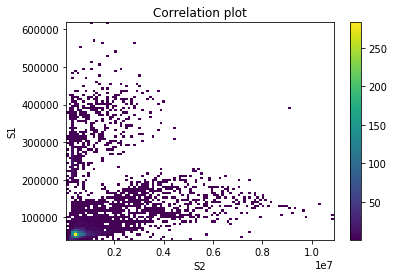

In [13]:
#Radon correlation plot
#setting the number of events to loop over
eventnum = len(Rn_data)

s1list = []
s2list = []

#looping over all events and putting them in collective lists
for event in Rn_data:
    s1list.append(event['s1'])
    s2list.append(event['s2'])
    
#print(s1list)
colors = (0,0,0)
area = np.pi*3

s1 = np.array(s1list)
s2 = np.array(s2list)

# Plot
plt.hist2d(s2,s1,bins=(100,100),cmin=1) #making the plot, leaving out empty bin
plt.title('Correlation plot')
plt.xlabel('S2')
plt.ylabel('S1')
plt.colorbar()
plt.show()

In [7]:
def Peaks(pulse, printall):
    
    # The standard variables
    q = 0
    left_t, right_t = 0, 0
    baseline = 16382.
    std = 2.3
    ch = pulse.channel
    wave = pulse.raw_data
    
    # The index for the minimum
    minindex = len(wave)
    
    # Variables for the average, the ratio and the slope
    avfound = 0
    samplelist = [wave[0]]
    ratio = 1
    slope = 0
    sw = 0

    s = np.std(wave)
    delta = baseline - np.min(wave)
    if min(s, delta) > 5*std:
        for samples in enumerate(wave):
            base_sub = samples[1] - baseline
            if abs(base_sub) > 5*std:
                q = q + base_sub
            
            # Compute the average of the previous samples
            av = np.average(samplelist)
            
            # left_t is assigned when a significant deviation from the average is recorded
            if abs(samples[1] - av) > 20 and left_t == 0:
                left_t = samples[0]
                
                # The sample value at left_t is kept for the slope calculation
                leftsample = samplelist[-1]
                if printall:
                    print("left_t here")
                avfound = av
             
            # Find the index for the minimum
            if samples[1] == np.min(wave):
                minindex = samples[0]

            # right_t is assigned in a similar way as left_t
            if abs(samples[1] - avfound) < 20 and samples[0] > minindex and right_t == 0: 
                right_t = samples[0]
                if printall:
                    print("right_t here")
                
            # Add the current sample to the sample list
            samplelist.append(samples[1])
            
            # A printing section in case the raw data needs to be analysed
            if printall:
                print(samples)
                print("Average:", av)
                if left_t == 0:
                    print("Average difference:", abs(samples[1] - av))
                else:
                    print("Average difference:", abs(samples[1] - avfound))
                print()
        
        # Calculate the ratio and the slope
        ratio = np.min(wave)/int(avfound)
        delta_x = minindex - left_t
        if delta_x != 0:
            slope = (np.min(wave) - leftsample)/delta_x
        
    else:
        baseline = np.average(wave)
        std = s
    width = right_t - left_t
    if width != 0:
        sw = slope/width
        if -q/width < 3*std or ratio >= 0.99:
            q = 0
    return (ch, q, width, pulse.left+left_t, sw)

In [16]:
def width_finder(boundary, eventnum, selected):
    """
    Finding the widths of the peaks in a certain event
    
    @param eventnum: The number of the events that is being looked at
    
    @type widthlist: list
    @param widthlist: contains the widths of the peaks in the given event
    
    @type returnlist: list
    @param returnlist: [[eventnumber], [s1 peaks], [s2 peaks]]
    """
    
    #setting
    event = 0
    returnlist = []
    widthlist = []
    
    if selected == False:
        for eventn in range(eventnum):
            print("currently working on event", eventn)
            returnlist.append([event, [],[]])
            
            event = Rn220.get_single_event(eventn)
        
            for p in event.pulses: #looping over pulses
                result = Peaks(p, False)
            
            
                if result[2] != 0:
                    widthlist.append(result[2])
                    if result[2]<boundary:#and len(returnlist[-1][1]) == 0:
                        returnlist[-1][1].append(result[2])
                    else:
                        returnlist[-1][2].append(result[2])            
            
            
    
    if selected == True:
        #looping over all selected events
        for event in Rn_data:
        
            print("currently working on event", event['event'])
            returnlist.append([event, [],[]])
            
            event = Rn220.get_single_event(event['event'])
        
            for p in event.pulses: #looping over pulses
                result = Peaks(p, False)
            
            
                if result[2] != 0:
                    widthlist.append(result[2])
                    if result[2]<boundary:#and len(returnlist[-1][1]) == 0:
                        returnlist[-1][1].append(result[2])
                    else:
                        returnlist[-1][2].append(result[2])
                
                

    return returnlist, widthlist


In [3]:


def width_finder(start, stop, boundary):
    """
    Finding the widths of the peaks in a certain event
    

In [ ]:
#Making a list of the first 1000 Rn-200 data events
masterlist = width_finder(100,1000,False) 

In [ ]:
#with open('parrot.pkl', 'wb') as f:
 #      pickle.dump(mylist, f)

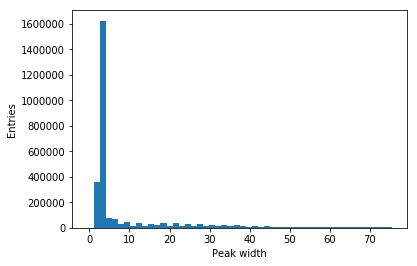

In [84]:
hist = masterlist[1]
n, bins, patches = plt.hist(hist, 50, range=(-0.5,75.5))
plt.xlabel('Peak width')
#plt.yscale('log')
plt.ylabel('Entries')
plt.savefig("Rn_peak_width_unselected.png")

In [2]:
#Making lists of the number of S1 and S2 peaks per event
s1numlist = []
s2numlist = []

for event in masterlist[0]:
    s1numlist.append(len(event[1]))
    s2numlist.append(len(event[2]))
    

#Making a histogram of the accumulated number of peaks per event over all PMTs    
hist = s2numlist
n, bins, patches = plt.hist(hist, 25, range=(-0.5,1000.5), alpha =0.5, label ='s2 peaks')
plt.hist(s1numlist, 25, range=(-0.5,1000.5), alpha =0.5, label='s1 peaks')
plt.xlabel('Total number of peaks per event on all channels')
#plt.yscale('log')
plt.ylabel('Entries')
plt.legend()
plt.savefig("numberofs1s2.png")

NameError: name 'masterlist' is not defined

In [71]:
#calculating the number of s1 peaks and the number of s2 peaks
s1s = 0
s2s = 0

for element in masterlist[0]:
    #print(element)
    s1s+=len(element[1])
    s2s+=len(element[2])
print("There are ",s1s," S1 peaks, and ", s2s," S2 peaks")

2491960 642548 0.2578484405849211


In [101]:
#Making lists of events where the number of S2 peaks is between 400 and 450 and those where it is between 0 and 100
doubles2s = []
singles2s = []

for event in masterlist[0]:
    if len(event[2]) > 400 and len(event[2]) < 450:
        doubles2s.append(event[0])
        
    if len(event[2]) > 0 and len(event[2]) < 100:
        singles2s.append(event[0])
        
print(doubles2s)
print(singles2s)

[9, 39, 42, 59, 76, 108, 116, 151, 180, 188, 226, 245, 265, 267, 311, 327, 330, 332, 341, 345, 346, 352, 359, 361, 429, 438, 454, 463, 496, 518, 519, 522, 525, 555, 592, 605, 628, 645, 679, 709, 712, 747, 753, 805, 809, 819, 847, 890, 908, 944, 956, 970, 977]
[0, 3, 6, 7, 18, 23, 30, 36, 43, 46, 47, 56, 65, 71, 78, 80, 84, 85, 87, 92, 94, 97, 99, 100, 102, 103, 105, 114, 115, 117, 119, 124, 125, 127, 131, 137, 141, 144, 148, 149, 155, 167, 169, 171, 182, 184, 193, 194, 197, 201, 203, 211, 214, 219, 230, 231, 233, 234, 241, 246, 248, 249, 252, 255, 256, 264, 270, 273, 277, 283, 288, 290, 292, 296, 297, 301, 304, 310, 314, 316, 320, 321, 322, 328, 329, 333, 334, 336, 338, 342, 348, 350, 354, 356, 362, 364, 372, 379, 382, 383, 385, 388, 393, 395, 396, 397, 401, 407, 411, 418, 419, 420, 423, 426, 428, 430, 431, 433, 441, 442, 446, 447, 448, 451, 452, 458, 469, 471, 473, 474, 477, 478, 482, 486, 497, 499, 509, 511, 517, 520, 527, 528, 529, 530, 532, 533, 537, 539, 543, 544, 551, 553, 556, 5

In [3]:
"""take gains into account for each adc value"""
"""only look at top PMTs (for position reconstruction)"""

# A waveform reader function
def Waveform(raw,eventnr):
    event = raw.get_single_event(eventnr)
    ch_top = eval(config['DEFAULT']['channels_top'])
    gain = eval(config['DEFAULT']['gains'])
                                
    #The variables that check if a channel is the minimum channel
    adcmin = 16382
    minchannel = 0
    
    #A list that holds all the channels with significant pulses 
    channellist = []
    
    #Create the datapoint arrays
    n = 350000  
    ts = np.ones((n_channels, n), dtype=np.int16)
    ts = ts * 16382 
    t = np.linspace(0, n, n) 
    counter = False
    #s = 0
    
    #Loop over all pulses in the event
    for p in event.pulses:
        ch = p.channel
        if ch in ch_top:  #only top PMTs
            i = np.zeros(n_channels, dtype = int)
            for adc in p.raw_data:
                try:
                #Add the ADC value to the appropriate channel array
                    ts[ch][p.left + i[ch]] = adc
                    #print("adc: ", adc)
                    if gain[ch]!=0:
                        adc_corrected = 16382 - (16382 - adc)/gain[ch]*4911399 #corrected by relative gain
                        #print("%: ", gain[ch]/4800000)
                    else:
                        adc_corrected = 0#np.inf #if we put 0 here, PMTs with 0 gain are taken into account for minchannel
                    #print("corrected: ",adc_corrected)
                    i[ch] = i[ch] + 1
                except IndexError:
                        #s += 1
                        counter = True
                        
                #Append all significant main channels to the list
                if adc_corrected < 15000 and ch not in channellist and ch in det_ch['tpc']:
                    channellist.append(ch)
                
                #Check which channel is the minimum channel
                if adc_corrected < adcmin:
                    adcmin = adc_corrected
                    minchannel = ch
                
    #Sort for convenience
    channellist.sort()
    return t, ts, channellist, minchannel, counter

KeyboardInterrupt: 

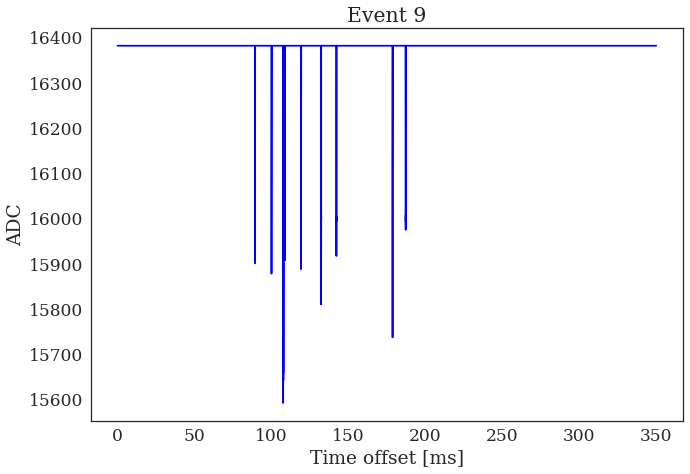

In [10]:
#Making waveforms of the events from the populations with a low number of peaks and a high number of peaks
import seaborn as sns
sns.set(style='white', font='serif', context='notebook', font_scale=1.7)

#Defining a function to make waveforms
def waveform_figures(Input, eventnumber, name):
    plt.rcParams["figure.figsize"] = (10, 7)
    figs, ax = plt.subplots()
    ax.plot(Input[0]/1000., Input[1][50], label='Channel' + str(254), color = 'blue')
    ax.set_ylabel("ADC")
    ax.set_xlabel("Time offset [ms]")
    ax.set_title('Event ' + str(eventnumber))
    #ax.legend()
    plt.tight_layout()
    fname = name+str(eventnumber)+'_better.pdf'
    figs.savefig(fname, dpi = (200))
    
#Looping over all events in the lists
for eventnumber in doubles2s:    
    Input = Waveform(Rn220,eventnumber)
    waveform_figures(Input, eventnumber, 'MultipleS2peaks_BroadWaveformRn_')
for eventnumber in singles2s:
    Input = Waveform(Rn220,eventnumber)
    waveform_figures(Input, eventnumber, 'SingleS2peaks_BroadWaveformRn_')    